In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
path = "data/sms_spam.csv"

In [3]:
sms_spam = pd.read_csv(path)
sms_spam

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


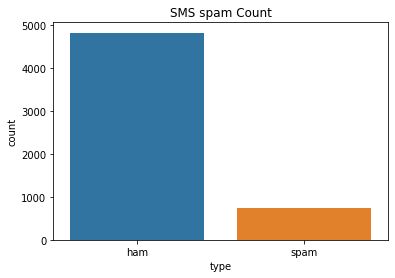

In [4]:
sns.countplot(data=sms_spam, x = "type")
plt.title("SMS spam Count")
plt.show()

> There's a huge inbalance of data in this dataset.

In [5]:
from collections import Counter

In [6]:
Counter(sms_spam.type.values)

Counter({'ham': 4827, 'spam': 747})

### Data preparation
* Remove numbers, punctuation and symbols from the copra.

In [84]:
labels = np.array([0 if i == "ham" else 1 for i in sms_spam.type.values ])

In [85]:
labels

array([0, 0, 1, ..., 0, 0, 0])

In [7]:
texts = sms_spam.text.values
texts

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

In [8]:
test = texts[2]
test

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [9]:
import re

In [42]:
def clean_text(sent):
    a = re.sub(r'\d\d?\w+', ' ', sent)
    b = re.sub(r'\d|\W', ' ', a)
    c = re.sub(r'\s+', ' ', b)
    c = c.lower()
    d = re.sub(r'\b[^a]{1}\b',' ', c)
    return re.sub(r'\s+', ' ', d).strip()

In [45]:
cleaned_text = np.array(list(map(clean_text, texts)))

### Vocabulary ``size`` aka number of unique words

In [53]:
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize

In [54]:
counter = Counter()
for sent in cleaned_text:
    words = word_tokenize(sent)
    for word in words:
        counter[word] += 1

In [56]:
counter.most_common(2)

[('to', 2253), ('you', 2245)]

In [57]:
vocab_size = len(counter)
vocab_size

7651

> We have **`7651`** unique words in our data.

### Creating **`word vectors`**.

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [62]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(cleaned_text)

In [65]:
word_indices = tokenizer.word_index
reversed_word_indices = dict([(v, k) for (k, v) in word_indices.items()])

In [70]:
def sequence_texts(sequence):
    
    return " ".join([reversed_word_indices[i] for i in sequence])

In [67]:
tokens_sequences = tokenizer.texts_to_sequences(cleaned_text)

In [69]:
print(tokens_sequences[:2])

[[44, 430, 3845, 768, 691, 606, 63, 6, 1216, 115, 310, 934, 2659, 1217, 55, 54, 3846, 126], [42, 311, 1367, 431, 1771]]


In [78]:
sequence_texts(tokens_sequences[0])

'go until jurong point crazy available only in bugis great world la buffet cine there got amore wat'

### Padiing the `sequences`.

In [79]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:
max_words = 100
tokens_sequence_padded = pad_sequences(tokens_sequences, maxlen=max_words, padding="post", truncating="post")

### Creating a `NN` for classification.

### Model ``Achitecture``

```py
        
                [ Embedding Layer]
                        |
                        |
[ LSTM ] <---- [Bidirectional Layer] ----> [GRU] (forward_layer)
 (backward_layer)       |
                        |
                 [ Flatten Layer]
                        |
                        |
                 [Dense Layer 1]
                        |
                        |    
                 [Dense Layer 2]
                        |
                        |
                 [Dense Layer 3] (output)

```

In [104]:
tokens_sequence_padded.shape,labels.shape

((5574, 100), (5574,))

In [106]:
tokens_sequence_padded[0]

array([  44,  430, 3845,  768,  691,  606,   63,    6, 1216,  115,  310,
        934, 2659, 1217,   55,   54, 3846,  126,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [109]:
forward_layer = keras.layers.GRU(64, return_sequences=True)
backward_layer = keras.layers.LSTM(64, activation='relu', return_sequences=True,
                       go_backwards=True)
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 32, input_length=max_words),
    keras.layers.Bidirectional(
        forward_layer,
        backward_layer=backward_layer
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= ['accuracy'],
    optimizer = keras.optimizers.Adam()
)

history = model.fit(
    x = tokens_sequence_padded,
    y =labels,
    epochs = 5,
    verbose = 1,
    validation_split = .2,
    shuffle=True,
    batch_size= 32,
    validation_batch_size = 16,
)

Epoch 1/5
140/140 [==============================] - 21s 108ms/step - loss: 0.3349 - accuracy: 0.8592 - val_loss: 0.0448 - val_accuracy: 0.9848
Epoch 2/5
140/140 [==============================] - 14s 100ms/step - loss: 367759489910.0399 - accuracy: 0.9907 - val_loss: 0.0520 - val_accuracy: 0.9857
Epoch 3/5
140/140 [==============================] - 14s 101ms/step - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0543 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 15s 107ms/step - loss: 0.0073 - accuracy: 0.9988 - val_loss: 0.0602 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 14s 101ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0795 - val_accuracy: 0.9857


### Model Training history.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

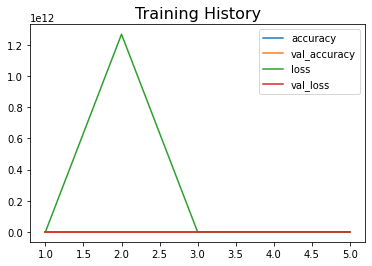

In [110]:
epochs = np.arange(1, 6)

plt.plot(epochs, history.history["accuracy"], label="accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="val_accuracy")

plt.plot(epochs, history.history["loss"], label="loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")

plt.legend()
plt.title("Training History", fontsize=16)
plt.show()

### Making predictions.

In [116]:
predictions = np.round(model.predict(tokens_sequence_padded[:10]), 1).reshape(1, -1)
predictions, labels[:10]

(array([[0., 0., 1., 0., 0., 1., 0., 0., 1., 1.]], dtype=float32),
 array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1]))